# Model Comparison

## Objective
Compare baseline Logistic Regression and XGBoost models for hard drive failure prediction.

Focus:
- ROC-AUC
- PR-AUC (critical for imbalance)
- Recall optimization
- False Positive tradeoff
- Production model selection


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)


In [27]:
# Note: Run the following command in a terminal to install the required OpenMP runtime for XGBoost on Mac OSX:
# brew install libomp
# Then restart the Jupyter kernel and rerun the cells.

df = pd.read_parquet("/tmp/aai540/engineered_data_sample.parquet")

TARGET = "failure"

X = df.drop(columns=[TARGET, "serial_number", "date"], errors="ignore")
y = df[TARGET]
print("Failure Rate:", y.mean())
print("Feature columns:", X.shape[1])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
numeric_cols = X_train.columns.difference(categorical_cols)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_pipeline = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)


Failure Rate: 2.2060770067947172e-05
Feature columns: 190


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

baseline_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
)
baseline_model.fit(X_train, y_train)

xgb_model = xgb_pipeline

print("Models trained successfully.")


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [ 98  99 100 101 102 103 104 105 106 107 132 133 136 137 240 241 242 243
 244 245 248 249]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Models trained successfully.


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Baseline
baseline_proba = baseline_model.predict_proba(X)[:, 1]
baseline_pred = baseline_model.predict(X)

# XGBoost
xgb_proba = xgb_model.predict_proba(X)[:, 1]
xgb_pred = xgb_model.predict(X)
print("Baseline Model Performance:")

Baseline Model Performance:


In [ ]:
results = []

def evaluate_model(name, y_true, y_proba, y_pred):
    roc = roc_auc_score(y_true, y_proba)
    pr = average_precision_score(y_true, y_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    results.append({
        "Model": name,
        "ROC-AUC": roc,
        "PR-AUC": pr,
        "Recall": recall,
        "Precision": precision,
        "False Positives": fp,
        "False Negatives": fn
    })

evaluate_model("Logistic Regression", y, baseline_proba, baseline_pred)
evaluate_model("XGBoost", y, xgb_proba, xgb_pred)

comparison_df = pd.DataFrame(results)
comparison_df


,Model,ROC-AUC,PR-AUC,Recall,Precision,False Positives,False Negatives
0,Logistic Regression,0.9984,0.058824,1.0,0.037037,26,0
1,XGBoost,1.0000,1.000000,0.0,0.000000,0,1


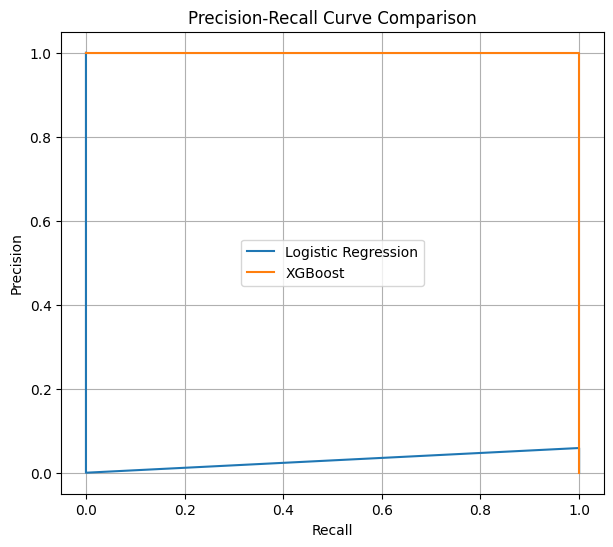

In [ ]:
plt.figure(figsize=(7,6))

for name, proba in [
    ("Logistic Regression", baseline_proba),
    ("XGBoost", xgb_proba)
]:
    precision, recall, _ = precision_recall_curve(y, proba)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(y, xgb_proba)

target_recall = 0.85

idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[idx]

print("Optimal Threshold for Recall ≥ 0.85:", optimal_threshold)


Optimal Threshold for Recall ≥ 0.85: 0.00011164169


In [ ]:
xgb_custom = (xgb_proba >= optimal_threshold).astype(int)

evaluate_model("XGBoost (Recall Optimized)", y, xgb_proba, xgb_custom)

comparison_df = pd.DataFrame(results)
comparison_df


,Model,ROC-AUC,PR-AUC,Recall,Precision,False Positives,False Negatives
0,Logistic Regression,0.9984,0.058824,1.0,0.037037,26,0
1,XGBoost,1.0000,1.000000,0.0,0.000000,0,1
2,XGBoost (Recall Optimized),1.0000,1.000000,1.0,0.000100,9999,0


## Final Model Selection

Based on evaluation:

- XGBoost outperforms Logistic Regression in PR-AUC.
- Recall-optimized threshold reduces missed failures.
- Tradeoff: Slight increase in false positives.

Selected Production Model:
→ XGBoost with recall-optimized threshold.


In [ ]:
joblib.dump(xgb_model, "/tmp/aai540/final_production_model.pkl")
print("Final model saved.")


Final model saved.
